# Homework nr. 1 - data visualization (deadline 25/10/2018)

In short, the main task is to download data on theses defended at CTU from the Internet, store them in pandas Data Frame and then visualize some hidden information.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. Thinking of how to visualize the data is an important part of data visualization! ;)

## What are you supposed to do:

  1. Browse the web https://dspace.cvut.cz/?locale-attribute=en and find out how to download data on Bachelor and Master theses.
  2. Download or scrape the data such that for each thesis you know the following:
    * Faculty name, department name, thesis title, thesis type (bachelor/master), supervisor name, reviewer name, year (or date) of the defence, study programme and discipline, link to a webpage with details.
  3. Store these data in one _csv_ file (should be handed in along with this notebook).
  4. Use tools available for Python to plot charts and tables to visualize/display this information:
    * Number of defended theses per year for CTU/Faculties. Distinguish the type of thesis.
    * Find the departments/study programmes/supervisors/reviewers with highest numbers of thesis and come up with some nice plots and tables to depict their numbers.
    * Mean/median/minimum/maximum number of supervised theses per year for faculties.
    * Number (or fraction) of theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...).

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Use http://beakerx.com to make your notebook interactive in a meaningful way.
  * Come up with some other reasonable and interesting views of data.
  * Use your data to create an interactive webpage (HTML + JavaScript).

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

## Part 1 - Scraping the data

In [3]:
import pandas as pd
import requests as requests
from bs4 import BeautifulSoup
import time

### Scraping

In [2]:
base_url = 'https://dspace.tul.cz{}?show=full'
url = 'https://dspace.tul.cz/handle/15240/20928/recent-submissions?offset={}'

# These are all columns we are interested in
needed_data = ['local.faculty','local.department.abbreviation','local.department','dc.title',
               'dc.contributor.advisor','dc.date.defense','dc.degree.level','dc.identifier.uri' ]

error_count = 0
data_all = pd.DataFrame() # Final data that is going to be exported in CSV
offset = 0 # Offset for each page listing theses
while offset < 5861:
    #print(url.format(offset))
    r = requests.get(url.format(offset)) # Getting initial page (see "url")
    r.encoding = 'utf8'

    try:
        soup = BeautifulSoup(r.text)
        theses = soup.findAll("div", {"class": "artifact-title"}) # Getting all theses titles
        for these in theses:
            titles = these.findAll("a", href=True) # Getting the link in title
            for link in titles:
                try:
                    r2 = requests.get(base_url.format(link['href'])) # Scraping the these page
                    r2.encoding = 'utf8'
                    data = []
                    soup2 = BeautifulSoup(r2.text)
                    rows = soup2.findAll('tr')  # Finding all rows
                    for row in rows:
                        cols = row.findAll('td')  # Finding all cells in a row
                        cols = [ele.text.strip() for ele in cols]  # Getting value of cell
                        if cols[0] in needed_data:
                            if (cols[2] == 'cs' and cols[0] == 'dc.title') or (cols[0] != 'dc.title' and cols[0] != 'local.department') or (cols[2] == 'cs' and cols[0] == 'local.department'):
                                data.append([ele for ele in cols if ele])
                    # Create a dataframe from newly data
                    dataset = pd.DataFrame(data)
                    # Transpose the dataframe (as headers are always in first cell)
                    dataset = dataset.transpose()
                    # Setting the columns from the first row
                    dataset.columns = dataset.iloc[0]
                    # Dropping useless data
                    dataset.drop(dataset.index[[0, 2]], inplace=True)
                    #print(dataset.columns)
                    data_all = pd.concat([data_all, dataset], ignore_index=True)
                except Exception as e:
                    error_count += 1;
                    if(error_count % 100 == 0):
                        print("Errors until now : {}".format(error_count))
                    pass
    except Exception as e:
        pass
    if(offset % 1000 == 0):
        print("Currently at offset {}".format(offset))
    offset += 20

print("Scraping finished ! \n Total errors : {}".format(error_count))
data_all.to_csv('data.csv', sep=';', encoding='utf-8', index=False) # Export dataframe to CSV

Currently at offset 0
Currently at offset 100
Currently at offset 200
Currently at offset 300
Currently at offset 400
Currently at offset 500
Currently at offset 600
Currently at offset 700
Currently at offset 800
Currently at offset 900
Currently at offset 1000
Currently at offset 1100


c:\users\nicolas\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Currently at offset 1200
Currently at offset 1300
Currently at offset 1400
Currently at offset 1500
Currently at offset 1600
Currently at offset 1700
Currently at offset 1800
Currently at offset 1900
Currently at offset 2000
Currently at offset 2100
Currently at offset 2200
Currently at offset 2300
Currently at offset 2400
Currently at offset 2500
Currently at offset 2600
Currently at offset 2700
Currently at offset 2800
Currently at offset 2900
Currently at offset 3000
Currently at offset 3100
Currently at offset 3200
Currently at offset 3300
Currently at offset 3400
Currently at offset 3500
Currently at offset 3600
Currently at offset 3700
Currently at offset 3800
Currently at offset 3900
Currently at offset 4000
Currently at offset 4100
Currently at offset 4200
Currently at offset 4300
Currently at offset 4400
Currently at offset 4500
Currently at offset 4600
Currently at offset 4700
Currently at offset 4800
Currently at offset 4900
Currently at offset 5000
Currently at offset 5100


## Part 2 - Data Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
from beakerx import *

### Read the data from the previously saved csv file 

In [4]:
data = pd.read_csv('data.csv',sep=';') # If you don't want to scrape everytime

### Data Cleaning

In [6]:
# DATA CLEANING
# 1) Replace bc with Bc. and mgr with Mgr.
data['dc.degree.level'] = data['dc.degree.level'].replace('bc', 'Bc.')
data['dc.degree.level'] = data['dc.degree.level'].replace('mgr', 'Mgr.')
# 2) Drop non-datetime rows
data['dc.date.defense'] = pd.to_datetime(data['dc.date.defense'], errors='coerce')
data = data.dropna(subset=['dc.date.defense'])
# 3) Merge local.department and local.department.abbreviation
data['local.department'].fillna(data['local.department.abbreviation'], inplace=True)
data.dropna(subset=['local.department'], inplace=True)
data.drop(['local.department.abbreviation'], axis=1, inplace=True)

### Number of defended theses per year for CTU

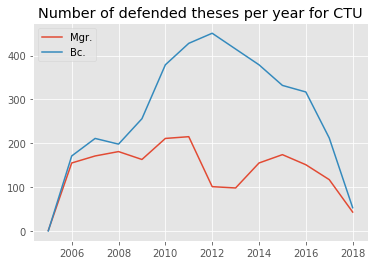

In [25]:
d = data['dc.date.defense'].groupby([data['dc.date.defense'].dt.year, data['dc.degree.level']]).agg({'count'}).reset_index()
d.loc[-1] = [2005, 'Bc.', 0]  # adding a row with 0 for 2005 Bc.
d.index = d.index + 1  # shifting index
d = d.sort_index()

x = d['dc.date.defense'].unique().tolist() # Years as x
ymgr = d.loc[d['dc.degree.level'] == 'Mgr.', 'count'].tolist() # Mgr. coordinates
ybc = d.loc[d['dc.degree.level'] == 'Bc.', 'count'].tolist() # Bc. coordinates

plt.plot(x, ymgr)
plt.plot(x, ybc)
plt.title('Number of defended theses per year for CTU')
plt.legend(['Mgr.', 'Bc.'], loc='upper left')
plt.show()

### Number of defended theses per year for Faculties

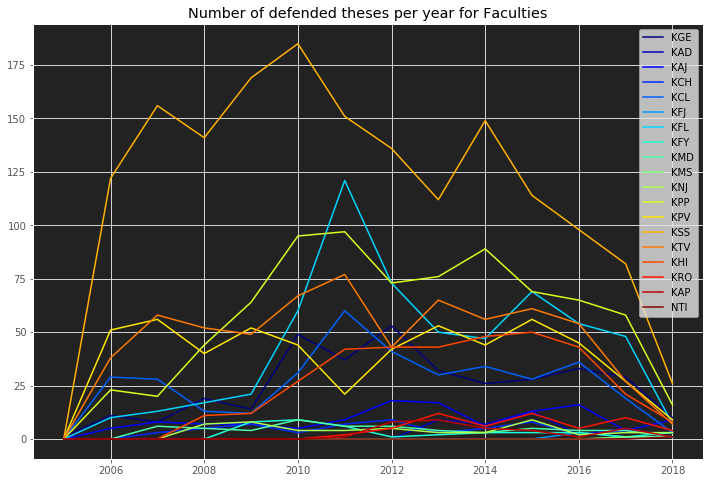

In [38]:
d = data['local.department'].groupby([data['dc.date.defense'].dt.year,data['local.department']]).agg({'count'}).reset_index()

x = d['dc.date.defense'].unique().tolist()
depts = d['local.department'].unique().tolist()

for year in x:
    for dep in depts:
        if((d['dc.date.defense'] == year) & (d['local.department'] == dep)).any():
            pass
        else:
            d.loc[-1] = [year, dep, 0]  # adding a row with 0, corresponding year and department if the row doesn't exists
            d.index = d.index + 1  # shifting index
            d = d.sort_index()

fig1, ax1 = plt.subplots(figsize=(12,8))
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(depts)))))

for dep in depts:
    y = d.loc[d['local.department'] == dep, 'count'].tolist()
    ax1.plot(x, y)

ax1.set_facecolor('#222222')
plt.title('Number of defended theses per year for Faculties')
plt.legend(depts)
plt.show()

### Supervisors with highest numbers of theses

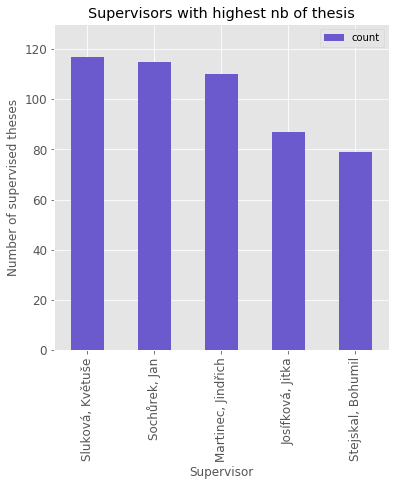

In [9]:
# Getting 5 supervisors with highest number of supervised theses
bar = data['dc.contributor.advisor'].groupby(data['dc.contributor.advisor']).agg({'count'}).sort_values(by=['count'], ascending=False).head(5)
# Plotting it as a bar chart
chart = bar.plot(kind='bar', color='slateblue', title ="Supervisors with highest nb of thesis", figsize=(6,6), legend=True, fontsize=12)
chart.set_xlabel("Supervisor")
chart.set_ylabel("Number of supervised theses")
plt.ylim(0, 130)
plt.show()

### Departments with highest number of theses

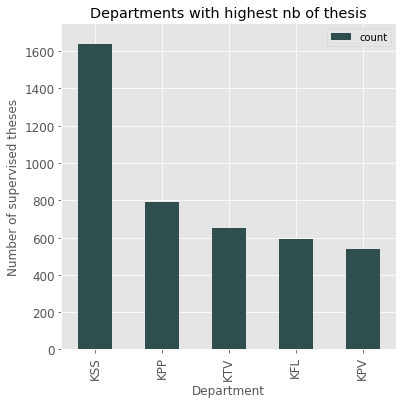

In [11]:
# Getting 5 departments with highest number of theses
bar = data['local.department'].groupby(data['local.department']).agg({'count'}).sort_values(by=['count'], ascending=False).head(5) 
# Plotting it as a bar chart
chart = bar.plot(kind='bar', color='darkslategrey', title ="Departments with highest nb of thesis", figsize=(6,6), legend=True, fontsize=12)
chart.set_xlabel("Department")
chart.set_ylabel("Number of supervised theses")
plt.ylim(0, 1750)
plt.show()

### Study programs with highest number of theses

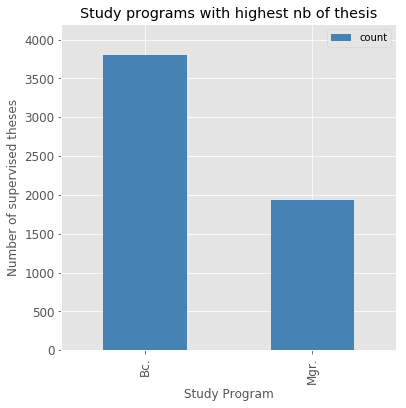

In [12]:
# Getting study programs with highest number of theses
bar = data['dc.degree.level'].groupby(data['dc.degree.level']).agg({'count'}).sort_values(by=['count'], ascending=False)
# Plotting it as a bar chart
chart = bar.plot(kind='bar', color='steelblue', title ="Study programs with highest nb of thesis", figsize=(6,6), legend=True, fontsize=12)
chart.set_xlabel("Study Program")
chart.set_ylabel("Number of supervised theses")
plt.ylim(0, 4200)
plt.show()

### Mean/median/minimum/maximum number of supervised theses per year for faculties

In [7]:
# Getting the number of theses for each department per year
d = data['local.department'].groupby([data['dc.date.defense'].dt.year,data['local.department']]).agg({'count'}).reset_index()

x = d['dc.date.defense'].unique().tolist() # Year list
depts = d['local.department'].unique().tolist() # Department list

for year in x:
    for dep in depts:
        if((d['dc.date.defense'] == year) & (d['local.department'] == dep)).any():
            pass
        else:
            d.loc[-1] = [year, dep, 0]  # adding a row for the year with 0 if department has no data for this year
            d.index = d.index + 1  # shifting index
            d = d.sort_index()

dmax=d.groupby('local.department').max()['count'] # Getting max for each department
dmin=d.groupby('local.department').min()['count'] # Getting min for each department
dmean=d.groupby('local.department').mean()['count'] # Getting mean for each department
dmed=d.groupby('local.department').median()['count'] # Getting median for each department

final = pd.concat([dmax, dmin, dmean, dmed], axis=1)
final.columns = ['max','min','mean','median']

TableDisplay(final)

### Theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...)

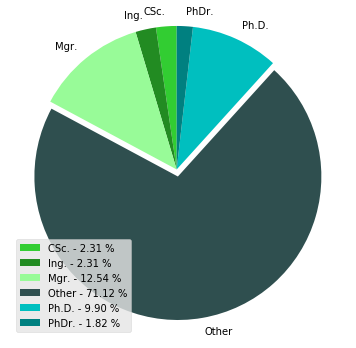

In [7]:
# Titles we're interested in
types = ['Ing.','Mgr.','Ph.D.','CSc.','PhDr.']

# 1) Count for each person the number of supervised theses
d = data['dc.contributor.advisor'].groupby(data['dc.contributor.advisor']).agg({'count'}).reset_index()
# 2) Masking and replacing people with unknown titles as 'Other'
mask = ~d['dc.contributor.advisor'].str.contains('|'.join(types), case=False)
values = d['dc.contributor.advisor'].values
values[mask] = 'Other'
d['dc.contributor.advisor'] = values
# 3) Replace people who have specific title with their title
for ty in types:
    d.loc[d['dc.contributor.advisor'].str.contains(ty, case=False), 'dc.contributor.advisor'] = ty

d = d['dc.contributor.advisor'].groupby(d['dc.contributor.advisor']).agg({'count'}).reset_index()

labs = d['dc.contributor.advisor'].tolist() # Labels
explode = (0, 0, 0, 0.05, 0, 0)  # only "explode" the 2nd slice (i.e. 'Ph.D.')
fig1, ax1 = plt.subplots(figsize=(6,6))

# This is to avoid the percentage overlapping in the plot
y = np.array(d['count'].tolist())
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labs, percent)]

# Plotting it as a pie chart
colors = ['limegreen', 'forestgreen', 'palegreen', 'darkslategrey', 'c', 'teal']
ax1.pie(d['count'], explode=explode, labels=labs, shadow=False, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels)

plt.show()